# Modeling and Simulation in Python

Chapter 7: Thermal systems

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [18]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### The coffee cooling problem.

I'll use a `State` object to store the initial temperature.


In [19]:
T1 = 87
init = State(temp=T1)
init

,value
temp,87


In [20]:
T1 = 90
init

,value
temp,87


And a `System` object to contain the system parameters.

In [21]:
coffee = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t0=0, 
                t_end=30,
                dt=1)
coffee

,value
init,temp 87 dtype: int64
volume,300
r,0.01
T_env,22
t0,0
t_end,30
dt,1


The `update` function implements Newton's law of cooling.

In [22]:
def update(state, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    T = state.temp
    T += -r * (T - T_env) * dt

    return State(temp=T)

Here's how it works.

In [23]:
update(init, coffee)

,value
temp,86.35


Now we can run simulations using the same function from the previous chapter.

In [56]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[t0] = init
    print('run sim init' + str(init))
    ts = linrange(t0, t_end-dt, dt)
    
    for t in ts:
        frame.loc[t+dt] = update_func(frame.loc[t], system)
    
    system.results = frame

And here's how it works.

In [48]:
run_simulation(coffee, update)
coffee.results

run sim inittemp    90
dtype: int64


,temp
0,90.000000
1,89.320000
2,88.646800
3,87.980332
4,87.320529
5,86.667323
6,86.020650
7,85.380444
8,84.746639
9,84.119173


Here's what the results look like.

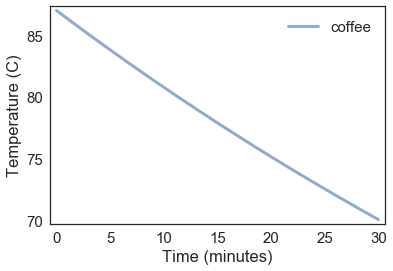

In [26]:
plot(coffee.results.temp, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

After running the simulation, we can extract the final temperature from the results.

In [27]:
def final_temp(system):
    """Final temperature.
    
    If system has no results, return initial temp.
    
    system: System object.
    
    returns: temperature (degC)
    """    
    if hasattr(system, 'results'):
        return system.results.temp[system.t_end]
    else:
        return system.init.temp

It will be convenient to wrap these steps in a function.  `kwargs` is a collection of whatever keyword arguments are provided; they are passed along as arguments to `System`.

In [57]:
def make_system(T_init=90, r=0.01, volume=300, t_end=30):
    """Runs a simulation with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(temp=T_init)
    print(init) 
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    print(system.init)
    return system

In [60]:
def sweep_init_temp(system, update_func):
    T_array = linspace(80, 100, 5)
    for i in T_array:
        system = make_system(T_init=i)
        print(i)
        run_simulation(system, update_func)
        print(system.results.temp)
        plot(system.results.temp, label='coffee')
        decorate(xlabel='Time (minutes)',
                 ylabel='Temperature (C)')
        

temp    80.0
dtype: float64
temp    80.0
dtype: float64
80.0
run sim inittemp    80.0
dtype: float64
0     80.000000
1     79.420000
2     78.845800
3     78.277342
4     77.714569
5     77.157423
6     76.605849
7     76.059790
8     75.519192
9     74.984000
10    74.454160
11    73.929619
12    73.410323
13    72.896219
14    72.387257
15    71.883385
16    71.384551
17    70.890705
18    70.401798
19    69.917780
20    69.438602
21    68.964216
22    68.494574
23    68.029628
24    67.569332
25    67.113639
26    66.662502
27    66.215877
28    65.773719
29    65.335981
30    64.902622
Name: temp, dtype: float64
temp    85.0
dtype: float64
temp    85.0
dtype: float64
85.0
run sim inittemp    85.0
dtype: float64
0     85.000000
1     84.370000
2     83.746300
3     83.128837
4     82.517549
5     81.912373
6     81.313249
7     80.720117
8     80.132916
9     79.551587
10    78.976071
11    78.406310
12    77.842247
13    77.283824
14    76.730986
15    76.183676
16    75.641840
17 

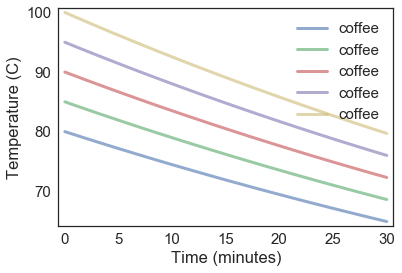

In [61]:
sweep_init_temp(coffee, update)

Here's how we use it:

In [31]:
coffee = make_system()
run_simulation(coffee, update)
final_temp(coffee)

72.299625390403094

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

In [62]:
milk = make_system(T_init=5, r=0.15, volume=50, t_end=15)
#picked new r because it seemed like the milk should get warmer faster. new value is arbitrary. 
#but felt like after fifteen min it would barely be colder than room temp.
run_simulation(milk, update)
final_temp(milk)

#coffee = System(init=init,
#                volume=300,
#                r=0.01,
#                T_env=22,
#                t0=0, 
#                t_end=30,
#                dt=1)
#coffee

temp    5
dtype: int64
temp    5
dtype: int64
run sim inittemp    5
dtype: int64


20.514978275278718

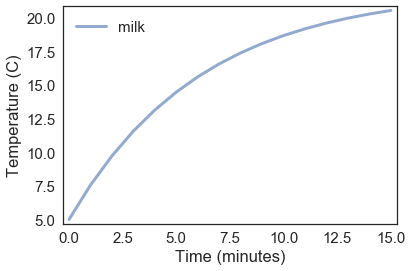

In [63]:
plot(milk.results.temp, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

### Using `fsolve`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [64]:
def func(x):
    return (x-1) * (x-2) * (x-3)

In [65]:
def sweep_init_temp2(system, update_func):
    T_array = linspace(5, 25, 5)
    for i in T_array:
        system = make_system(T_init=i)
        print(i)
        run_simulation(system, update_func)
        print(system.results.temp)
        plot(system.results.temp, label='milk')
        decorate(xlabel='Time (minutes)',
                 ylabel='Temperature (C)')

temp    5.0
dtype: float64
temp    5.0
dtype: float64
5.0
run sim inittemp    5.0
dtype: float64
0     5.000000
1     5.170000
2     5.338300
3     5.504917
4     5.669868
5     5.833169
6     5.994837
7     6.154889
8     6.313340
9     6.470207
10    6.625505
11    6.779250
12    6.931457
13    7.082143
14    7.231321
15    7.379008
16    7.525218
17    7.669966
18    7.813266
19    7.955133
20    8.095582
21    8.234626
22    8.372280
23    8.508557
24    8.643472
25    8.777037
26    8.909267
27    9.040174
28    9.169772
29    9.298074
30    9.425094
Name: temp, dtype: float64
temp    10.0
dtype: float64
temp    10.0
dtype: float64
10.0
run sim inittemp    10.0
dtype: float64
0     10.000000
1     10.120000
2     10.238800
3     10.356412
4     10.472848
5     10.588119
6     10.702238
7     10.815216
8     10.927064
9     11.037793
10    11.147415
11    11.255941
12    11.363382
13    11.469748
14    11.575050
15    11.679300
16    11.782507
17    11.884682
18    11.985835
19    

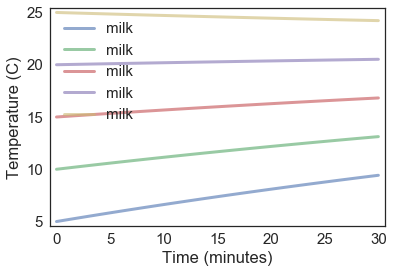

In [66]:
sweep_init_temp2(milk, update)

`modsim.py` provides `fsolve`, which does some error-checking and then runs `scipy.optimize.fsolve`.  The first argument is the function whose roots we want.  The second argument is an initial guess.

In [67]:
fsolve(func, x0=0)

array([ 1.])

Usually the root we get is the one that's closest to the initial guess.

In [68]:
fsolve(func, 1.9)

array([ 2.])

In [69]:
fsolve(func, 2.9)

array([ 3.])

But not always.

In [70]:
fsolve(func, 1.5)

array([ 3.])

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [72]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(r=r)
    print(r)
    run_simulation(system, update)
    return final_temp(system) - 70

With `r=0.01`, we end up a little too warm.

In [73]:
error_func1(r=0.01)

temp    90
dtype: int64
temp    90
dtype: int64
0.01
run sim inittemp    90
dtype: int64


2.2996253904030937

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [74]:
solution = fsolve(error_func1, 0.01, xtol=1e-8)
r_coffee = solution[0]
r_coffee

temp    90
dtype: int64
temp    90
dtype: int64
0.01
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01150871]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01154231]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01154308]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01154308]
run sim inittemp    90
dtype: int64
temp    90
dtype: int64
temp    90
dtype: int64
[ 0.01154308]
run sim inittemp    90
dtype: int64


0.011543084583978345

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [75]:
coffee = make_system(r=r_coffee)
run_simulation(coffee, update)
final_temp(coffee)

temp    90
dtype: int64
temp    90
dtype: int64
run sim inittemp    90
dtype: int64


70.0

**Exercise:**  When you call `fsolve`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `fsolve` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `fsolve`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [76]:
r_milk = 0.12
#picked this value because it seemed pretty close from my graph above.
milk = make_system(T_init=5, t_end=15, r=r_milk)
run_simulation(milk, update)
final_temp(milk)

temp    5
dtype: int64
temp    5
dtype: int64
run sim inittemp    5
dtype: int64


19.501444483698084

In [77]:
def error_func2(r):
    system = make_system(r=r, T_init=5, t_end=15)
    print(r)
    run_simulation(system, update)
    return final_temp(system) - 20

In [78]:
error_func2(r=0.12)

temp    5
dtype: int64
temp    5
dtype: int64
0.12
run sim inittemp    5
dtype: int64


-0.49855551630191641

In [79]:
solution = fsolve(error_func2, 0.12, xtol=1e-8)
r_milk = solution[0]
r_milk

temp    5
dtype: int64
temp    5
dtype: int64
0.12
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.12]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.12]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.12]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.12]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.1317062]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.13283515]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.13295952]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.13296079]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.13296079]
run sim inittemp    5
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64
[ 0.13296079]
run sim inittemp    5
dt

0.13296078935466449

In [80]:
milk = make_system(r=r_milk, T_init=5, t_end=15)
run_simulation(milk, update)
final_temp(milk)

temp    5
dtype: int64
temp    5
dtype: int64
run sim inittemp    5
dtype: int64


19.999999999999996

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [81]:
def mix(s1, s2):
    """Simulates the mixture of two liquids.
    
    s1: System representing coffee
    s2: System representing milk
    
    returns: System representing the mixture
    """
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=s1.r)
    
    return mixture

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [82]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
run_simulation(coffee, update)
final_temp(coffee)

temp    90
dtype: int64
temp    90
dtype: int64
run sim inittemp    90
dtype: int64


70.0

In [83]:
milk = make_system(T_init=5, t_end=30, r=r_milk, volume=50)
run_simulation(milk, update)
final_temp(milk)

temp    5
dtype: int64
temp    5
dtype: int64
run sim inittemp    5
dtype: int64


21.764705882352942

Here's what the results look like.

Saving figure to file chap07-fig01.pdf


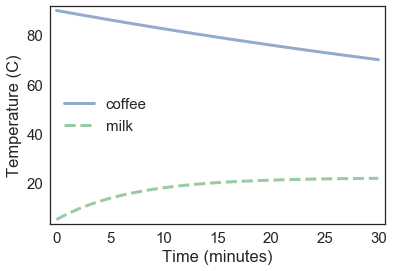

In [84]:
plot(coffee.results.temp, label='coffee')
plot(milk.results.temp, '--', label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('chap07-fig01.pdf')

Here's what happens when we mix them.

In [85]:
mix_last = mix(coffee, milk)
final_temp(mix_last)

temp    63.109244
dtype: float64
temp    63.109244
dtype: float64


63.109243697478988

And here's what we get if we add the milk immediately.

In [86]:
coffee = make_system(T_init=90, r=r_coffee, volume=300)
milk = make_system(T_init=5, r=r_milk, volume=50)

temp    90
dtype: int64
temp    90
dtype: int64
temp    5
dtype: int64
temp    5
dtype: int64


In [87]:
mix_first = mix(coffee, milk)
mix_first.t_end = 30
run_simulation(mix_first, update)
final_temp(mix_first)

temp    77.857143
dtype: float64
temp    77.857143
dtype: float64
run sim inittemp    77.857143
dtype: float64


61.428571428571438

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [93]:
def run_and_mix(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    run_simulation(milk, update)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

In [100]:
def sweep_init_temp2(system, update_func):
    T_array = linspace(5, 25, 5)
    for i in T_array:
        system = make_system(T_init=i)
        print(i)
        run_simulation(system, update_func)
        print(system.results.temp)
        plot(system.results.temp, label='milk')
        decorate(xlabel='Time (minutes)',
                 ylabel='Temperature (C)')

temp    5.0
dtype: float64
temp    5.0
dtype: float64
5.0
run sim inittemp    5.0
dtype: float64
0     5.000000
1     5.170000
2     5.338300
3     5.504917
4     5.669868
5     5.833169
6     5.994837
7     6.154889
8     6.313340
9     6.470207
10    6.625505
11    6.779250
12    6.931457
13    7.082143
14    7.231321
15    7.379008
16    7.525218
17    7.669966
18    7.813266
19    7.955133
20    8.095582
21    8.234626
22    8.372280
23    8.508557
24    8.643472
25    8.777037
26    8.909267
27    9.040174
28    9.169772
29    9.298074
30    9.425094
Name: temp, dtype: float64
temp    10.0
dtype: float64
temp    10.0
dtype: float64
10.0
run sim inittemp    10.0
dtype: float64
0     10.000000
1     10.120000
2     10.238800
3     10.356412
4     10.472848
5     10.588119
6     10.702238
7     10.815216
8     10.927064
9     11.037793
10    11.147415
11    11.255941
12    11.363382
13    11.469748
14    11.575050
15    11.679300
16    11.782507
17    11.884682
18    11.985835
19    

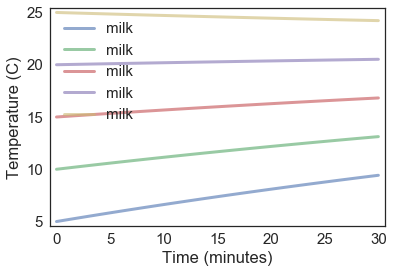

In [101]:
sweep_init_temp2(milk, update)

In [102]:
def run_and_mix_and_sweep(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    sweep_init_temp2(milk, update)
 
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

In [103]:
run_and_mix_and_sweep()
plot(final_temp(mixture))

TypeError: run_and_mix_and_sweep() missing 1 required positional argument: 't_add'

We can try it out with a few values.

In [169]:
run_and_mix(0)

61.428571428571438

In [170]:
run_and_mix(15)

62.90280912845234

In [171]:
run_and_mix(30)

63.109243697478988

And then sweep a range of values for `t_add`

In [175]:
sweep = SweepSeries()
for t_add in linrange(0, 30, 2):
    temp = run_and_mix(t_add)
    sweep[t_add] = temp

Here's what the result looks like.

Saving figure to file chap07-fig02.pdf


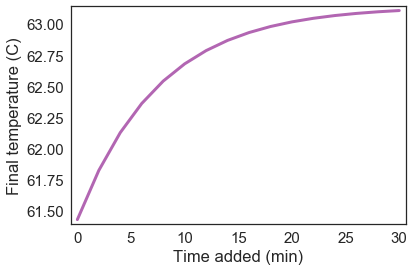

In [176]:
plot(sweep, color='purple')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)',
         legend=False)

savefig('chap07-fig02.pdf')

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [188]:
#Now you can only add the milk at two points, the beggining and the end. 
#Assume that both refrigerators are equally cold, so the milk will be 5 deg C whenever you add it. 

def run_and_mix(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    #remove the run_simulation becaause the milk is not warming up
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

In [193]:
run_and_mix(0)

61.428571428571438

In [194]:
run_and_mix(30)

60.714285714285715

In [195]:
#so better to add milk at beggining

### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [196]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
    
    Adds TimeFrame to `system` as `results`
    
    system: System object
    """
    unpack(system)
    
    T_init = init.temp    
    ts = linrange(t0, t_end, dt)
    
    temp_array = T_env + (T_init - T_env) * exp(-r * ts)
    temp_series = TimeSeries(temp_array, index=ts)
    
    system.results = TimeFrame(temp_series, columns=['temp'])

Here's how we run it.  From the analysis, we have the computed value of `r_coffee2`

In [197]:
r_coffee2 = 0.011610223142273859

In [198]:
init = State(temp=90)
coffee2 = System(init=init, T_env=22, r=r_coffee2, 
                 t0=0, t_end=30)
run_analysis(coffee2)
final_temp(coffee2)

70.0

And we can compare to the results from simulation.

In [199]:
init = State(temp=90)
coffee = System(init=init, T_env=22, r=r_coffee, 
                t0=0, t_end=30, dt=1)
run_simulation(coffee, update)
final_temp(coffee)

70.0

They are identical except for small roundoff errors.

In [200]:
coffee.results - coffee2.results

,temp
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,0.000000e+00
9,0.000000e+00
